# Projet CNN : Qui a peint ce tableau ?

## 1) Chargement des librairies

In [1]:
import os, sys, math
import numpy as np
import random as rd
import pandas as pd
import seaborn as sns
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2024-11-28 15:47:09.733583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 15:47:10.355838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 15:47:10.623094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 15:47:12.377136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 15:47:17.704790: W tensorflow/compiler/tf2

## 2) Chargement des données

In [2]:
# Chemin des données
path = os.path.join(os.getcwd(), "art-challenge", "images_hq")

# Chargement des données
data = []
for artist_folder in os.listdir(path):
    artist_path = os.path.join(path, artist_folder)
    for image_file in os.listdir(artist_path):
        image_path = os.path.join(artist_path, image_file)
        with Image.open(image_path) as image:
            width, height = image.size
        data.append({"image_path": image_path,
                     "artist": artist_folder,
                     "width": width,
                     "height": height})

# Création du dataframe
data = pd.DataFrame(data)

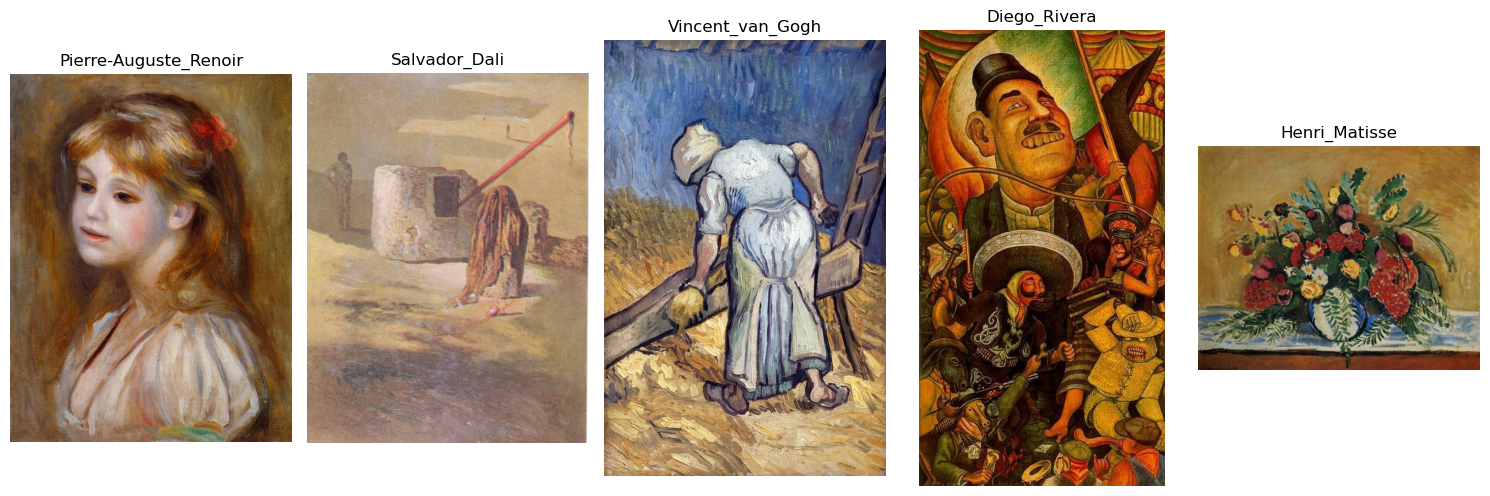

In [3]:
# Affiche des tableaux au hasard
random_idx = rd.sample(range(len(data)), 5)
plt.figure(figsize = (15, 5))
for i, idx in enumerate(random_idx):
    image = Image.open(data.loc[idx, "image_path"]).convert("RGB")
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(data.loc[idx, "artist"])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3) Analyse exploratoire des données

### a) Etude du nombre de peinture pour chaque artiste

Dans un premier temps, observons la répartition du nombre de peintures pour chaque artiste pour voir si la base de données est équilibrée.

In [4]:
def histogram_images_per_artist(df, quantile = True):
    
    # Compte le nombre d'images pour chaque artiste
    counter_artists = Counter(df["artist"])
    
    # Trie les artistes par nombre d'images décroissant
    sorted_artists = sorted(counter_artists.items(), key = lambda x: x[1], reverse = True)
    names = [artist for artist, _ in sorted_artists]
    counts = [count for _, count in sorted_artists]
    
    # Calcule les quantiles à 25% et 75% du nombre d'images par artiste
    quantile_25 = int(np.percentile(counts, 25))
    quantile_75 = int(np.percentile(counts, 75))
    
    # Histogramme
    plt.figure(figsize = (10, 7))
    plt.bar(names, counts, color = "skyblue")
    if quantile:
        plt.axhline(quantile_75, color = "green", linestyle = "--", label = "Quantile 75% (" + str(quantile_75) + " images)")
        plt.axhline(quantile_25, color = "red", linestyle = "--", label = "Quantile 25% (" + str(quantile_25) + " images)")
        plt.legend(fontsize = 12)
    plt.xticks(rotation = 90, ha = "center")
    plt.xlabel("Artistes", fontsize = 12)
    plt.ylabel("Nombre de peintures", fontsize = 12)
    plt.title("Nombre de peintures par artiste", fontsize = 15)
    plt.tight_layout()
    plt.show()

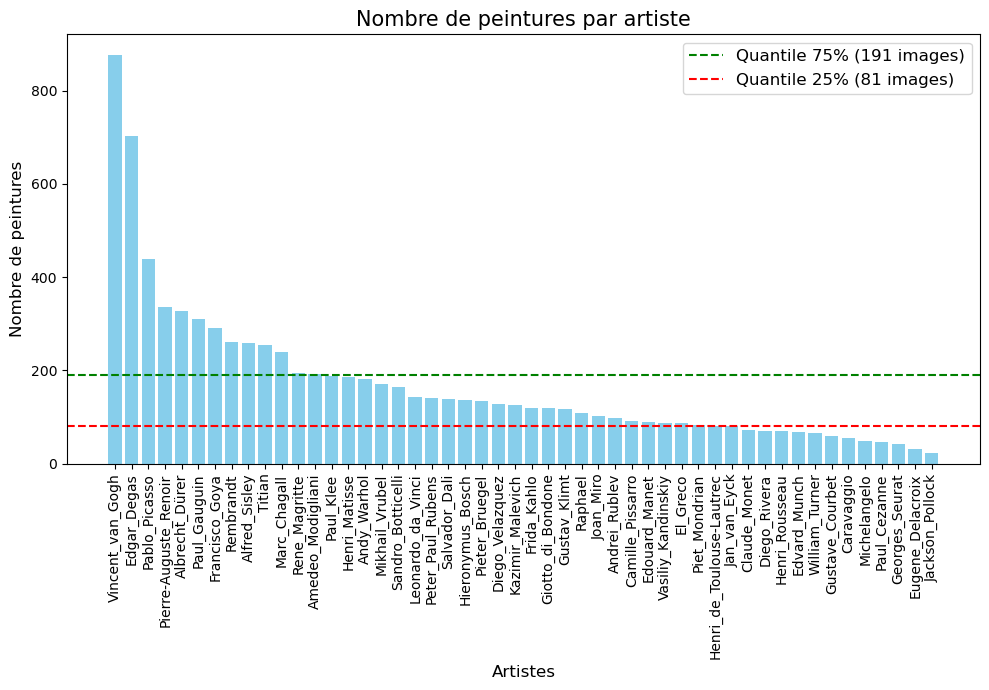

In [5]:
histogram_images_per_artist(data, True)

Nos données présentent un déséquilibre notable. Certains artistes comptent moins de 80 tableaux, ce qui nous amène à les exclure. D'autres, comme Vincent Van Gogh, Edgar Degas ou Pablo Picasso, sont surreprésentés. Pour tous ces artistes ayant plus de 200 oeuvres, nous réduirons leur nombre en retirant aléatoirement des tableaux afin d'équilibrer la distribution.

In [6]:
filtered_data = data.copy()

# Supprime les artistes avec moins de 80 tableaux
counter_artists = Counter(data["artist"])
artists_to_keep = [artist for artist, count in counter_artists.items() if count >= 80]
filtered_data = data[data["artist"].isin(artists_to_keep)]

# Réduit le nombre d'image maximum à 200
artists_reduced = []
for artist, count in filtered_data.groupby("artist"):
    if len(count) > 200:
        sample = count.sample(n = 200)
    else:
        sample = count
    artists_reduced.append(sample)
filtered_data = pd.concat(artists_reduced, ignore_index = True)

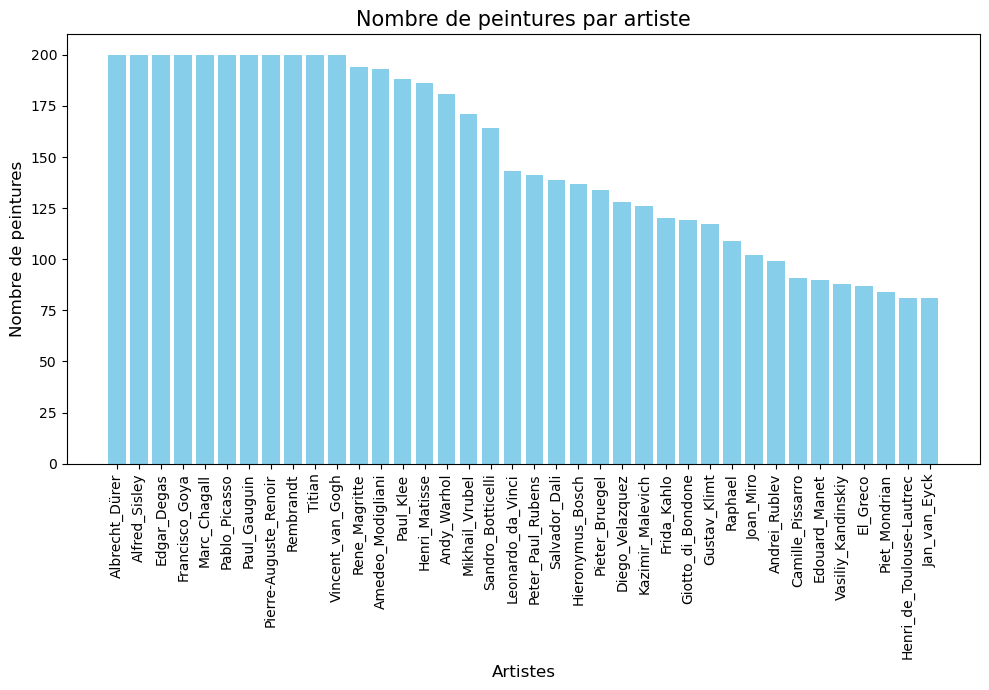

In [7]:
histogram_images_per_artist(filtered_data, False)

In [8]:
print("Nombre initial de tableaux : ", len(data))
print("Nombre initial d'artistes : ", len(data["artist"].unique()), "\n")

print("Nouveau nombre de tableaux : ", len(filtered_data))
print("Nouveau nombre d'artistes : ", len(filtered_data["artist"].unique()))

Nombre initial de tableaux :  8446
Nombre initial d'artistes :  50 

Nouveau nombre de tableaux :  5693
Nouveau nombre d'artistes :  38


### b) Etude des dimensions des images

Ensuite nous allons comparer les différentes dimensions des peintures.

In [10]:
def boxplot_dimensions(df):
    
    # Récupère les dimensions
    height = df["height"]
    width = df["width"]

    # Calcul des médianes
    median_height = height.median()
    median_width = width.median()

    # Boxplot
    plt.figure(figsize = (8, 5))
    plt.boxplot([height, width],
                patch_artist = True,
                boxprops = dict(facecolor = "lightblue"),
                medianprops = dict(color = "red"),
                flierprops = dict(marker = ".", markersize = 3),
                widths = 0.3)
    plt.text(1, median_height + 0.04 * median_height, str(median_height), color = "red", ha = "center", fontsize = 9)
    plt.text(2, median_width + 0.04 * median_width, str(median_width), color = "red", ha = "center", fontsize = 9)
    plt.xticks([1, 2], ["Longueur", "Largeur"])
    plt.ylabel("Nombre de pixel", fontsize = 12)
    plt.title("Boxplot des dimensions des images", fontsize = 15)
    plt.tight_layout()
    plt.show()

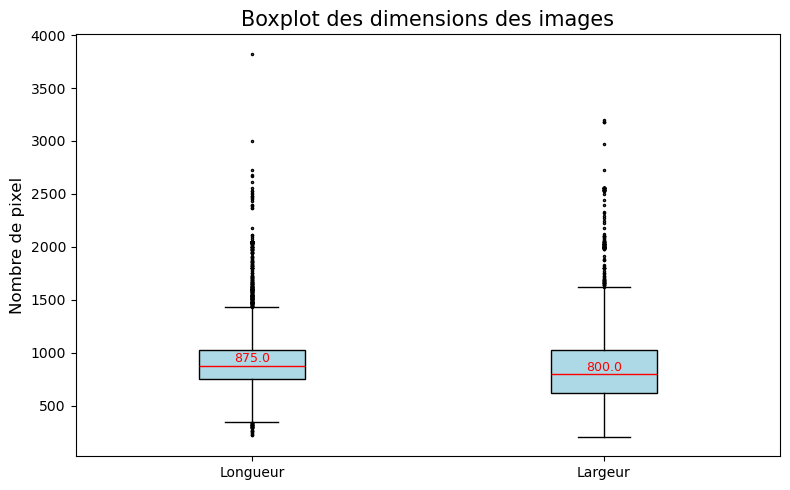

In [11]:
boxplot_dimensions(filtered_data)

A la vue de ces boxplot, nous avons décidé que nous redimensionnerons toutes les images du jeu de données en carrés de taille 800 * 800.

Cependant vérifions que nous ne perdons pas une information importante en faisant cela. En effet si un artiste a toujours les mêmes dimensions pour ses peintures, nous pouvons en tenir compte dans la cassification.

In [12]:
def boxplot_dimensions_per_artist(df):

    # Groupe les longueurs et les largeurs par artiste
    artists = df["artist"].unique()
    heigth_per_artist = [df[df["artist"] == artist]["height"] for artist in artists]
    width_per_artist = [df[df["artist"] == artist]["width"] for artist in artists]

    # Boxplot des longueurs
    plt.figure(figsize = (10, 7))
    plt.boxplot(heigth_per_artist,
                labels = artists,
                patch_artist = True,
                boxprops = dict(facecolor = "lightblue"),
                medianprops = dict(color = "red"),
                flierprops = dict(marker = ".", markersize = 3),
                widths = 0.7)
    plt.xticks(rotation = 90, ha = "center")
    plt.ylabel("Nombre de pixel", fontsize = 12)
    plt.title("Boxplot des longueurs des images par artiste", fontsize = 15)
    plt.tight_layout()
    plt.show()

    # Boxplot des largeurs
    plt.figure(figsize = (10, 7))
    plt.boxplot(width_per_artist,
                labels = artists,
                patch_artist = True,
                boxprops = dict(facecolor = "lightblue"),
                medianprops = dict(color = "red"),
                flierprops = dict(marker = ".", markersize = 3),
                widths = 0.7)
    plt.xticks(rotation = 90, ha = "center")
    plt.ylabel("Nombre de pixel", fontsize = 12)
    plt.title("Boxplot des largeurs des images par artiste", fontsize = 15)
    plt.tight_layout()
    plt.show()

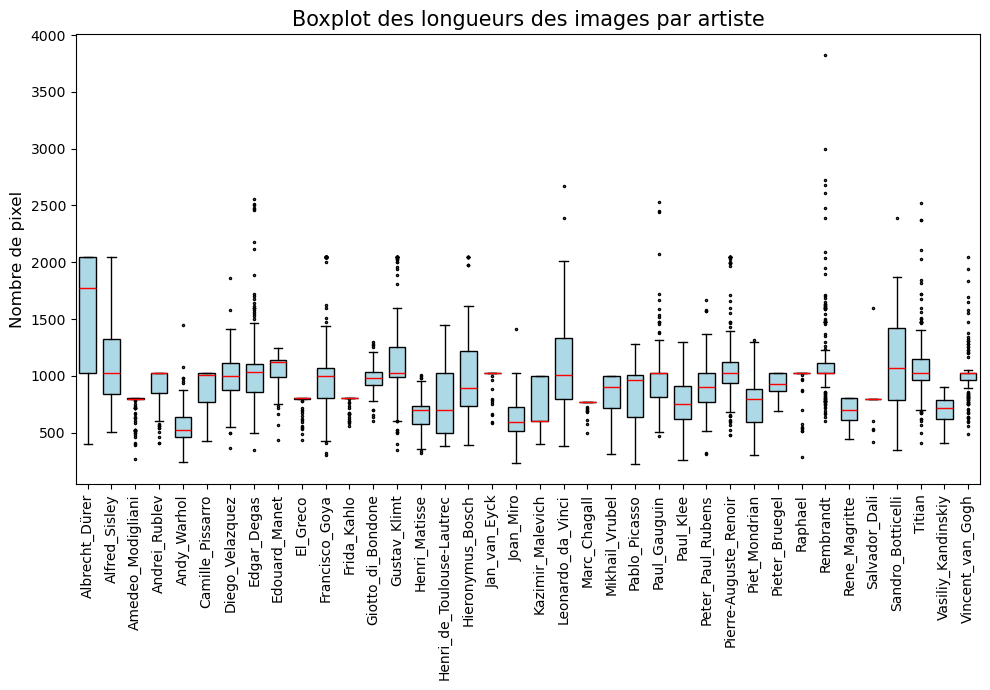

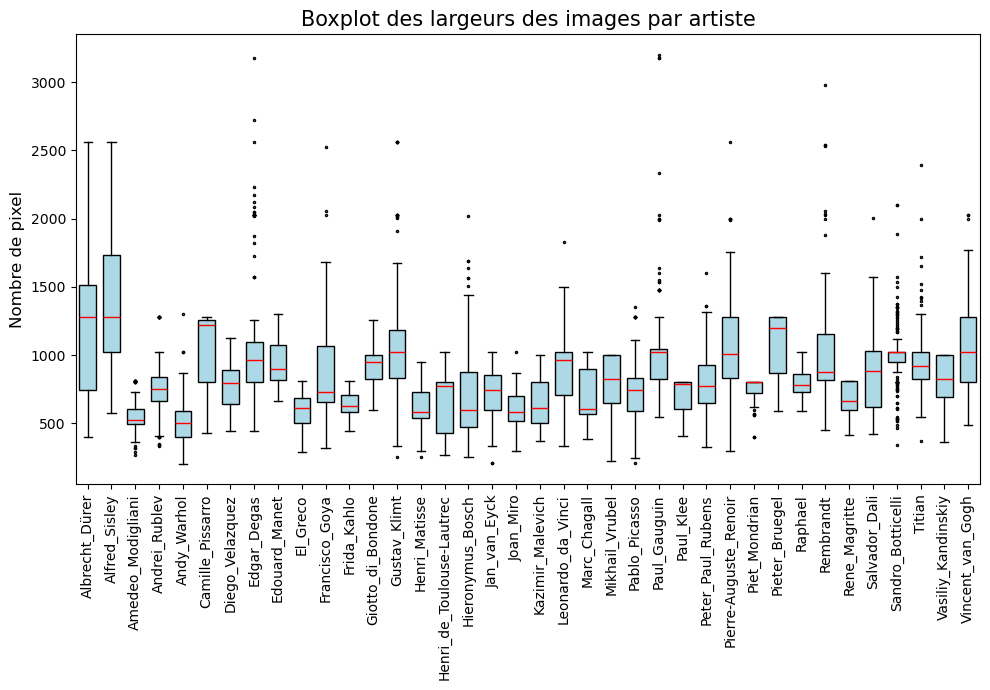

In [13]:
boxplot_dimensions_per_artist(filtered_data)

Dans ces boxplots, nous constatons que la majorité des artistes produisent des oeuvres de tailles variées. Cependant, certains artistes, tels qu'Amedeo Modigliani, El Greco, Frida Kahlo, Jan Van Eyck, Marc Chagall, Raphael et Salvador Dali, ont des peintures avec des longueurs uniformes. En revanche, la largeur des oeuvres est plus diversifiée, et aucun artiste ne présente une largeur constante pour ses tableaux. Par conséquent, nous avons décidé de ne pas inclure les dimensions initiales des oeuvres dans la classification.

### c) Etude de la nationalité et du style

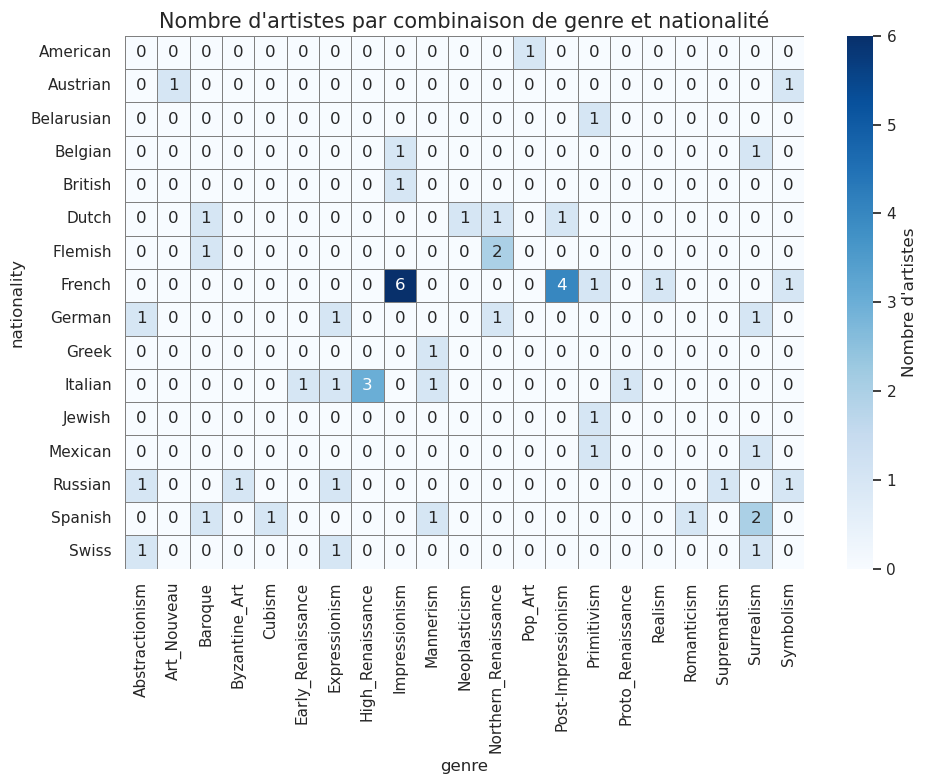

In [42]:
# Charge le fichier CSV
CSV_path = os.path.join(os.getcwd(), "art-challenge", "artists.csv")
data_artists = pd.read_csv(CSV_path)

# Mise en forme du dataframe
data_artists["name"] = data_artists["name"].str.replace(" ", "_")
data_artists["genre"] = data_artists["genre"].str.replace(" ", "_")
data_artists["genre"] = data_artists["genre"].str.split(',')
data_artists["nationality"] = data_artists["nationality"].str.split(',')

# Retire les artistes avec moins de 80 tableaux
artists_to_keep = [artist for artist in filtered_data["artist"].unique()]
data_artists = data_artists[data_artists["name"].isin(artists_to_keep)]

# Réalise un tableau croisé sur le genre et la nationalité
data_artists = data_artists.explode("genre").explode("nationality")
tableau = pd.crosstab(index = data_artists["nationality"], columns = data_artists["genre"])
sns.set(style = "whitegrid")
plt.figure(figsize = (10, 8))
sns.heatmap(tableau, annot = True, fmt = "d", cmap = "Blues", linewidths = .5, linecolor = "gray", cbar_kws = {"label": "Nombre d'artistes"})
plt.title("Nombre d'artistes par combinaison de genre et nationalité", fontsize = 15)
plt.tight_layout()
plt.show()

Nous avons envisagé d'intégrer davantage de données sur les artistes pour affiner la classification de leurs tableaux. Selon nous, les critères les plus pertinents seraient la nationalité et le genre. Bien que l'on aurait pu exploiter les biographies des artistes et extraire des éléments clés de leur vie pour les relier aux œuvres, cette approche serait bien plus complexe et nécessiterait un travail d'une autre ampleur.

En analysant le tableau à double entrée, nous constatons que la plupart des combinaisons de genre et de nationalité ne concernent qu'un seul artiste. Ajouter ces informations supplémentaires rendrait le modèle trop simple et ne justifierait pas l'utilisation d'un CNN.

De plus, bien qu'il soit possible de reconnaître un style de tableau à partir de l'image, il est moins raisonnable d'essayer de deviner la nationalité de l'artiste à partir de celle-ci. C'est pourquoi nous avons choisi de ne pas ajouter de données supplémentaires.

## 4) Préparation des données

Nous allons diviser les données en deux ensembles : data_train et data_test. Les images de l'ensemble data_train seront soumises à des techniques de data augmentation afin d'augmenter la diversité des données d'entraînement, tandis que les images de data_test resteront inchangées.

In [14]:
# Encode le nom des artistes
label_encoder = LabelEncoder()
filtered_data["artist_encoded"] = label_encoder.fit_transform(filtered_data["artist"])

# Divise les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(filtered_data, test_size = 0.3, stratify = filtered_data["artist_encoded"])

In [15]:
image_size = (800, 800)
batch_size = 20


# Augmentation des données
test_datagen = ImageDataGenerator(rescale = 1./255)

train_datagen = ImageDataGenerator(rotation_range = 40,
                                   rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

# Chargement des ensembles de données
test_gen = test_datagen.flow_from_dataframe(test_data,
                                            x_col = "image_path",
                                            y_col = "artist_encoded",
                                            target_size = image_size,
                                            batch_size = batch_size,
                                            class_mode = "raw",
                                            shuffle = False)

train_gen = train_datagen.flow_from_dataframe(train_data,
                                              x_col = "image_path",
                                              y_col = "artist_encoded",
                                              target_size = image_size,
                                              batch_size = batch_size,
                                              class_mode = "raw",
                                              shuffle = True)


Found 1708 validated image filenames.
Found 3985 validated image filenames.


## 5) Entraînement du CNN